In [15]:
import os
import json
import glob
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations 

In [16]:
DIGIT_MAPPING = {
    0: 'zero',
    1: 'one',
    2: 'two',
    3: 'three',
    4: 'four',
    5: 'five',
    6: 'six',
    7: 'seven',
    8: 'eight',
    9: 'nine'
}

## Gender dependent

In [17]:
PATH = '../sync_result'

In [18]:
channels = [1024,128,64]
techniques = ['non_pretrain', 'pretrain']
result = {}
for gender in ['all', 'female', 'male']:
    result[gender] = {}
    for c in channels:
        for tech in techniques:
            key = '%s_%s' % (c, tech)
            if tech == 'non_pretrain':
                files = glob.glob(os.path.join(PATH, tech, "%s_%s_exp*.csv"%(c,'non-pretrained')))
            else:
                files = glob.glob(os.path.join(PATH, tech, "%s_%s_exp*.csv"%(c,'pretrained')))
            df = pd.DataFrame()
            for f in files:
                df = pd.concat([df, pd.read_csv(f)], ignore_index=True)

            result[gender][key] = df.groupby(['phase', 'gender', 'loop'])['eer'].mean()['eval'][gender].to_list()    




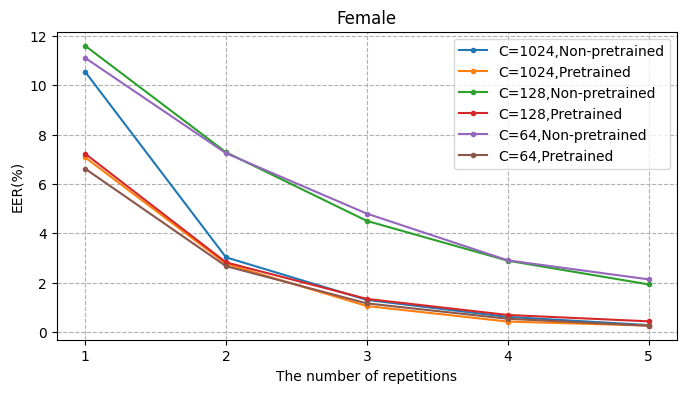

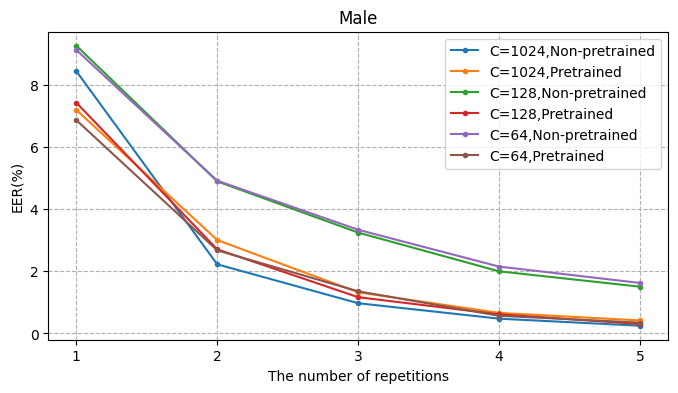

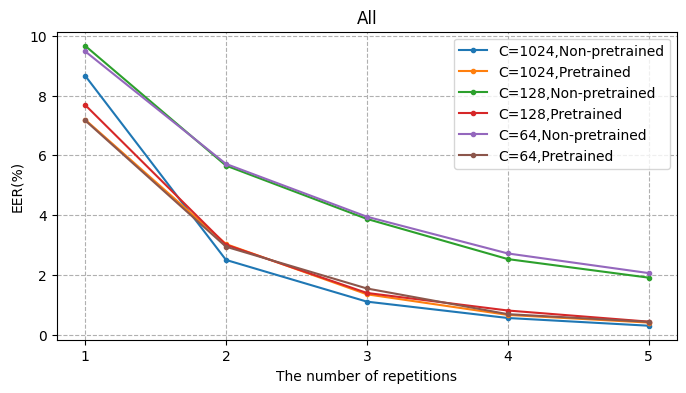

In [19]:
for gender in ['female', 'male', 'all']:
    data = result[gender]
    legends = []
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(111)
    for k in data:
        leg = 'C=%s,%s'
        if 'non_pretrain' in k:
            tech_str = 'Non-pretrained'
        else:
            tech_str = 'Pretrained'
        
        C = k.split('_')[0]
        legends.append(leg%(C,tech_str))
        ax.plot([loop for loop in range(1,6)],data[k],marker='.')
    plt.title(gender.capitalize())
    plt.ylabel('EER(%)')
    plt.xlabel('The number of repetitions')
    plt.xticks([loop for loop in range(1,6)])
    plt.legend(legends)
    plt.grid(linestyle='--')
    # # plt.savefig('sync_result/new_images/comparison_%s.png'%(gender),bbox_inches='tight')
    plt.show()
    



## Gender independent

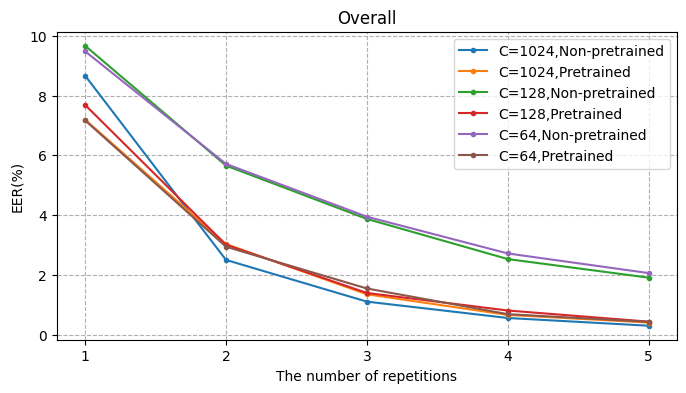

In [20]:
channels = [1024,128,64]
techniques = ['non_pretrain', 'pretrain']
result = {}
for c in channels:
    for tech in techniques:
        key = '%s_%s' % (c, tech)
        if tech == 'non_pretrain':
                files = glob.glob(os.path.join(PATH, tech, "%s_%s_exp*.csv"%(c,'non-pretrained')))
        else:
            files = glob.glob(os.path.join(PATH, tech, "%s_%s_exp*.csv"%(c,'pretrained')))
        df = pd.DataFrame()
        for f in files:
            df = pd.concat([df, pd.read_csv(f)], ignore_index=True)

        result[key] = df.groupby(['phase', 'gender', 'loop'])['eer'].mean()['eval'][gender].to_list()
legends = []
data = result
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
for k in data:
    leg = 'C=%s,%s'
    if 'non_pretrain' in k:
        tech_str = 'Non-pretrained'
    else:
        tech_str = 'Pretrained'
    
    C = k.split('_')[0]
    legends.append(leg%(C,tech_str))
    ax.plot([loop for loop in range(1,6)],data[k],marker='.')
plt.title('Overall')
plt.ylabel('EER(%)')
plt.xlabel('The number of repetitions')
plt.xticks([loop for loop in range(1,6)])
plt.legend(legends)
plt.grid(linestyle='--')
# plt.savefig('sync_result/new_images/comparison_overall.png',bbox_inches='tight')
plt.show()


# Visualization

In [21]:
def compute_average_result(files, type='json'):
    assert type in ['json', 'dataframe']
    if type == 'dataframe':
        df = pd.DataFrame()
        for f in files:
            df = pd.concat([df, pd.read_csv(f)], ignore_index=True)
        
            average = df.groupby(['phase', 'gender', 'text']).mean()

        return average
    elif type == 'json':
            result = {}
            for i, f in enumerate(files):
                result[i] = json.load(open(f,'r'))
            phases = ['eval']
            metrics = ['eer', 'minDCF']
            genders = ['female', 'male', 'all']
            final_result = {}
            # word = {}
            for phase in phases:
                final_result[phase] = {}
                # word[phase] = {}
                for gender in genders:
                    final_result[phase][gender] = {}
                    # word[phase][gender] = {}
                    for metric in metrics:
                        final_result[phase][gender][metric] = {}
                        # word[phase][gender][metric] = {}
                        for i in result[0][phase][gender][metric]:
                            temp = []
                            for exp in result:
                                try:
                                    temp.append(result[exp][phase][gender][metric][i])
                                except:
                                    temp.append(result[exp][phase][gender][metric][str(i)])
                            value = np.mean(temp, axis=0)
                            try:
                                final_result[phase][gender][metric][i] = list(value)
                            except: 
                                final_result[phase][gender][metric][i] = value
            return final_result            
    
    return None

In [23]:
def visualize_result(final_result,
                    path_to_save=None,
                    start_loop=1,
                    end_loop = 5,
                    genders =  ['female', 'male', 'all'],
                    metric = 'eer',
                    limit=True):
    if limit:
        a = []
        for gender in genders:
            for v in final_result['eval'][gender][metric].values():
                    a.extend(v)
            if len(a) == 0:
                continue
            min_ = min(a)
            max_ = max(a)

    for _, gender in enumerate(genders):
        # plt.figure(figsize=(12,4))
        name_set = list(final_result.keys())
        fig = plt.figure(figsize=(8,4))
        ax = fig.add_subplot(111)
        for idx,set in enumerate(name_set):
            set_result = final_result[set]
            # print(set_result[gender][metric])
            for i in range(0,10):
                try:
                    ax.plot([j for j in range(start_loop, end_loop+1)],set_result[gender][metric][i])
                except:
                    ax.plot([j for j in range(start_loop, end_loop+1)],set_result[gender][metric][str(i)])
        ax.set_xticks([ i for i in range(start_loop,end_loop+1)])
        ax.set_xlabel('The number of repetitions')
        if limit:
            ax.set_ylim((min_-0.5,max_+0.5))
        if metric == 'eer':
            y_label = 'EER (%)'
        else:
            y_label = 'minDCF'

        ax.set_ylabel(y_label)
        ax.set_title(gender.capitalize())
        ax.grid(linestyle='--')
        # ax.legend([DIGIT_MAPPING[i] for i in range(0,10)], loc='upper left', ncol=1, bbox_to_anchor=[1,1], title='Text')
        plt.legend([DIGIT_MAPPING[i] for i in range(0,10)], loc='upper left', ncol=1, bbox_to_anchor=[1,1], title='Text')
        if path_to_save is not None:
            plt.savefig(path_to_save + '_%s.png'%(gender), bbox_inches='tight')
        plt.show()
        

../sync_result\images\1024_non_pretrain
1024_non_pretrain


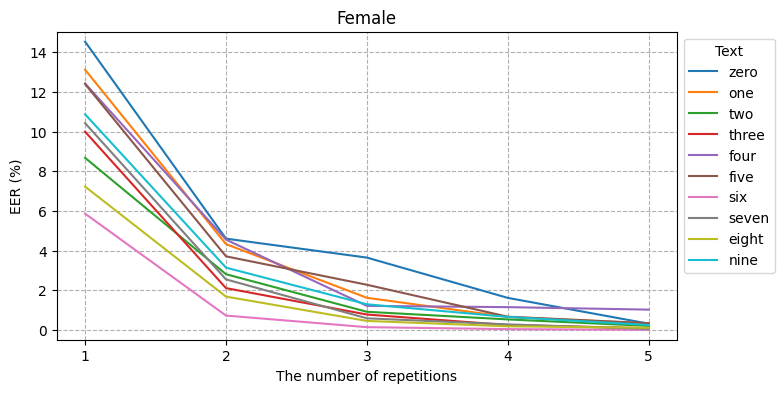

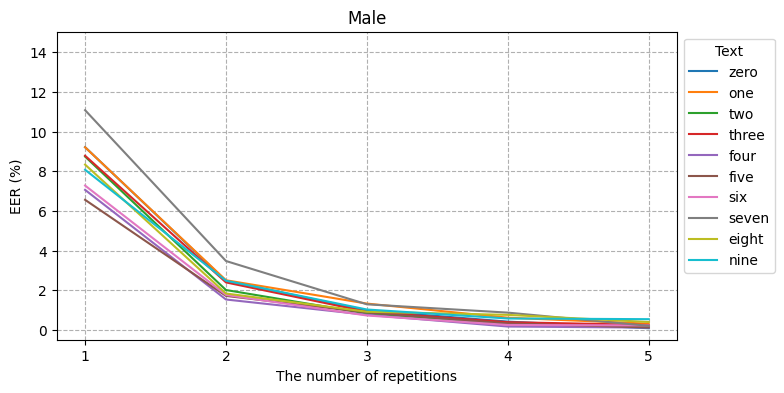

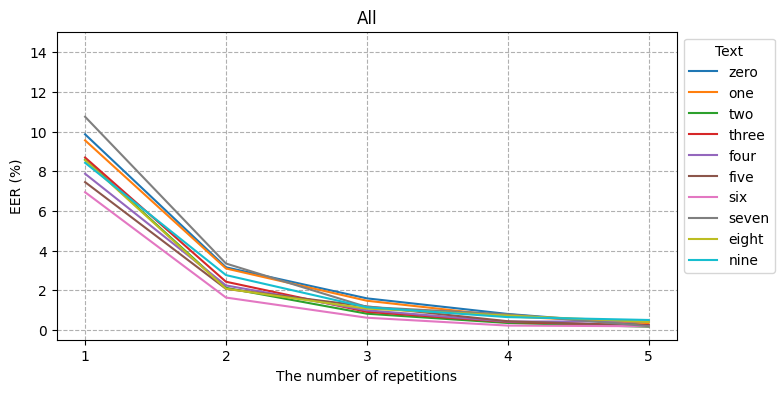

../sync_result\images\1024_pretrain
1024_pretrain


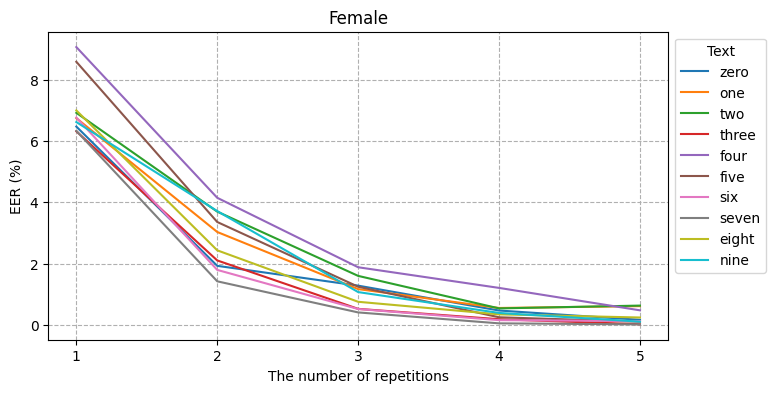

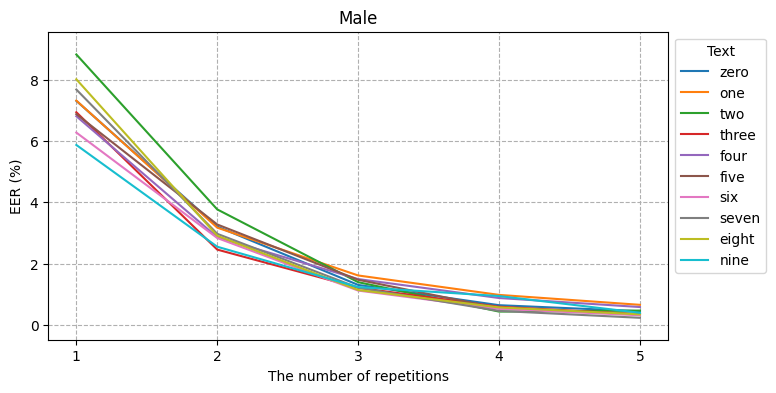

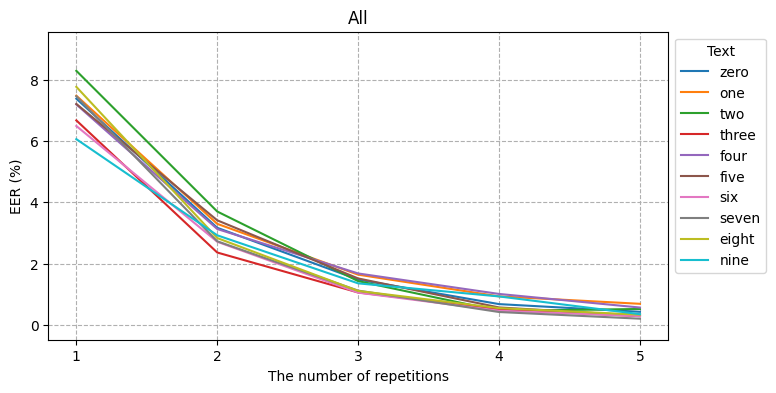

../sync_result\images\128_non_pretrain
128_non_pretrain


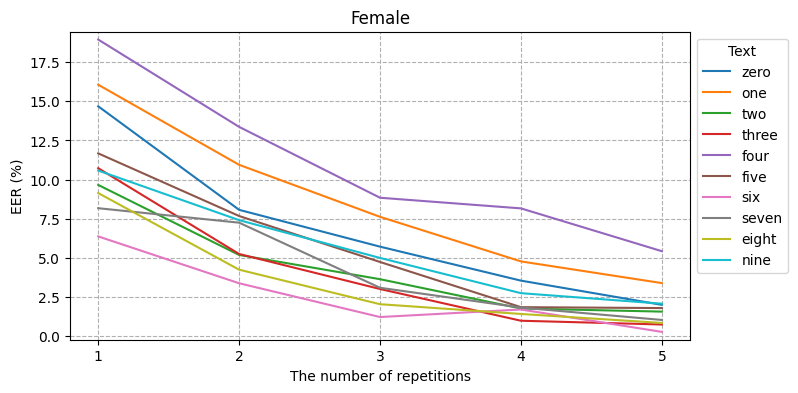

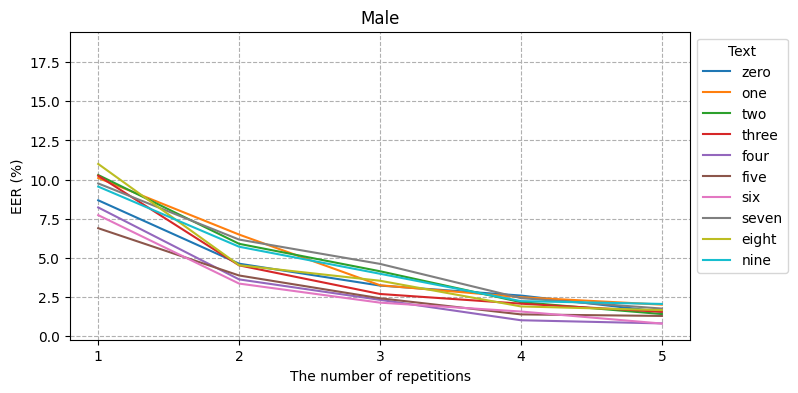

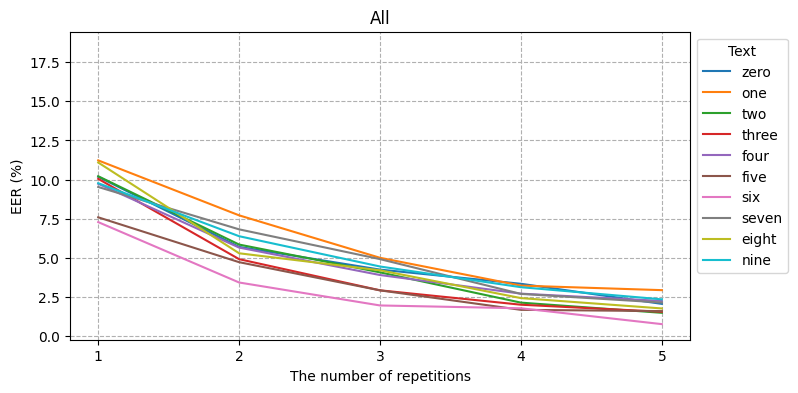

../sync_result\images\128_pretrain
128_pretrain


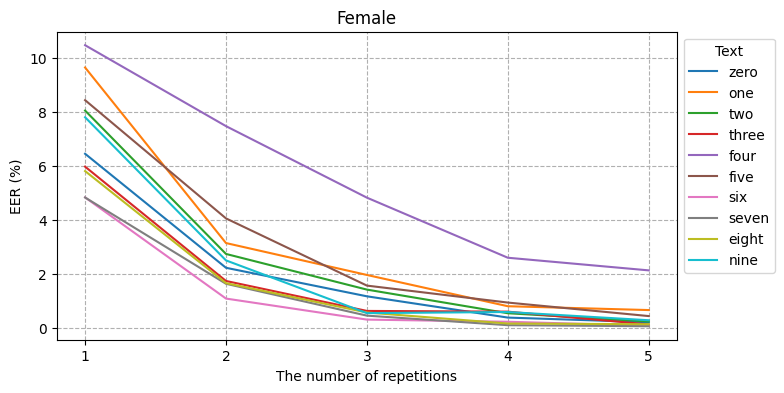

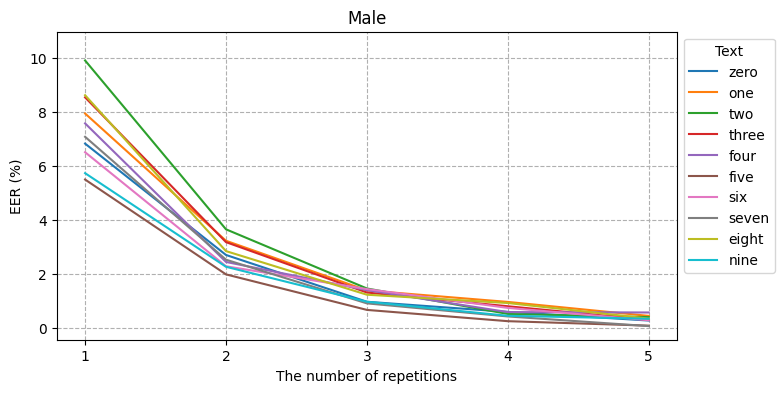

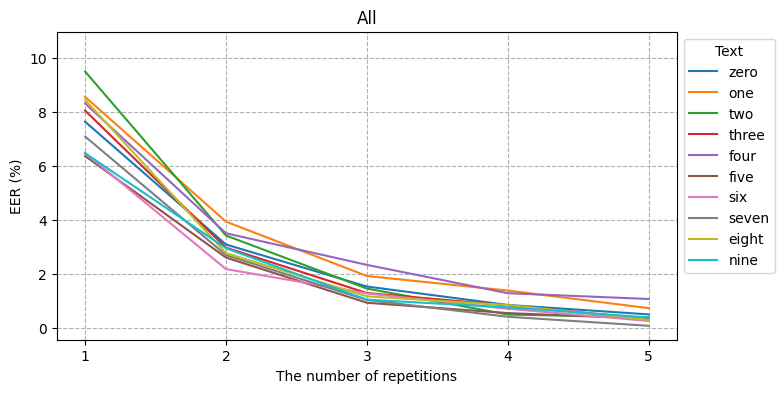

../sync_result\images\64_non_pretrain
64_non_pretrain


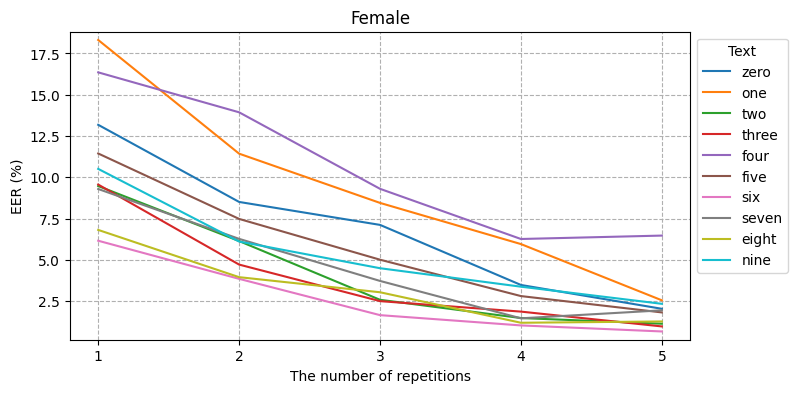

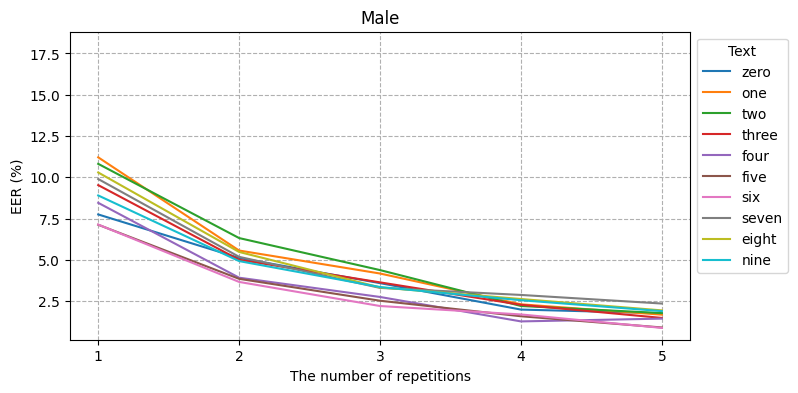

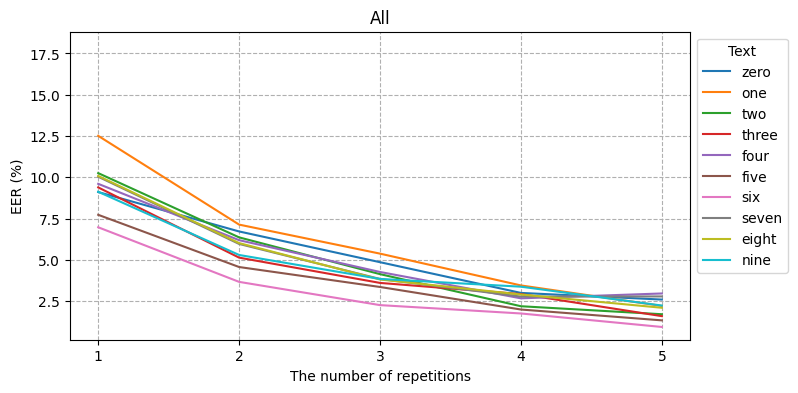

../sync_result\images\64_pretrain
64_pretrain


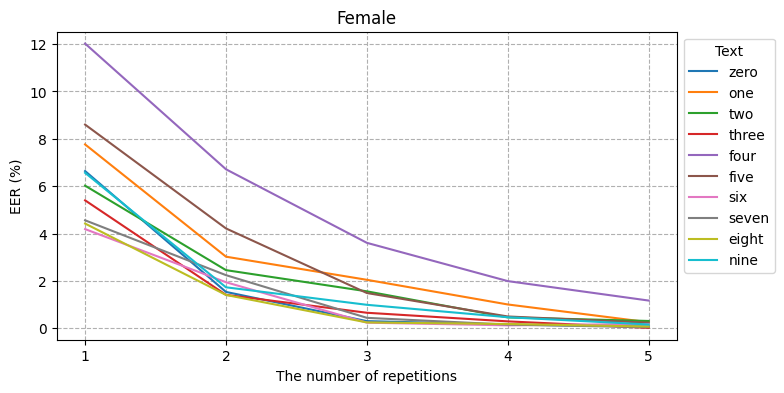

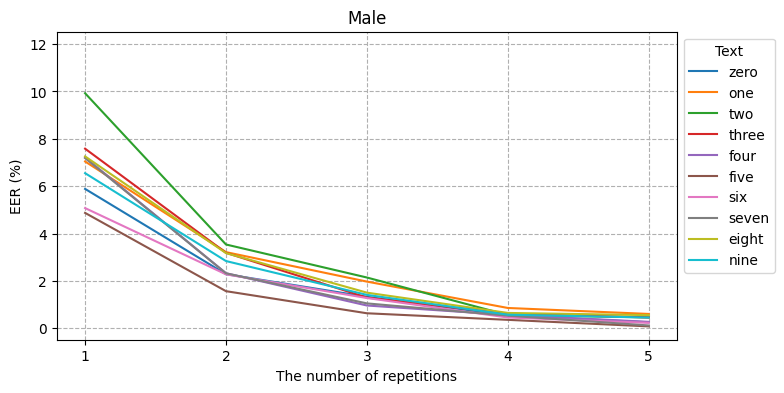

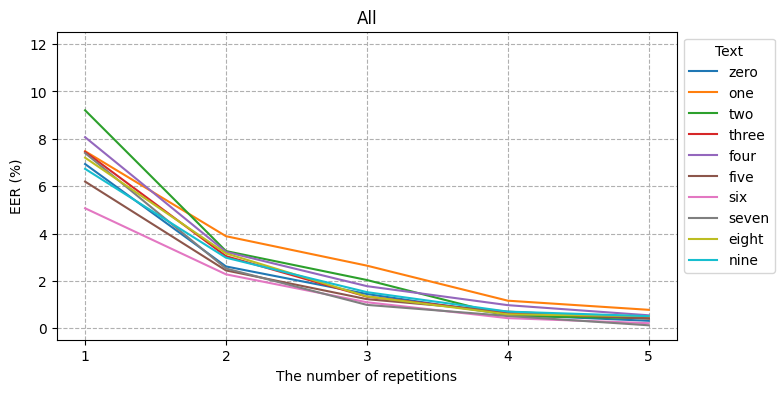

In [24]:
channels = [1024,128,64]
techniques = ['non_pretrain','pretrain']
for c in channels:
    for tech in techniques:
        key = '%s_%s' % (c, tech)
        if tech == 'non_pretrain':
            files = glob.glob(os.path.join(PATH, tech, "%s_%s_exp*.json"%(c,'non-pretrained')))
        else:
            files = glob.glob(os.path.join(PATH, tech, "%s_%s_exp*.json"%(c,'pretrained')))
        path_to_save = os.path.join(PATH,'images',key)
        os.makedirs(path_to_save,exist_ok=True)
        print(path_to_save)
        average = compute_average_result(files,
                                         type='json')
        print(key)
        visualize_result(average,path_to_save=path_to_save,limit=True)

In [32]:
def draw_bar_chart(filter,path_to_save=None):
    param = [-0.2, 0, +0.2]
    plt.figure(figsize=(12,6))
    # plt.grid(zorder=-1,linestyle='--')
    # data_vis = dict(sorted(filter[gender][metric].items(), key=lambda item: item[1]))
    plt.bar(np.arange(len(filter['female']['eer'])) - 0.2, list(filter['female']['eer'].values()),width=0.2)
    plt.bar(np.arange(len(filter['male']['eer'])), list(filter['male']['eer'].values()),width=0.2)
    plt.bar(np.arange(len(filter['all']['eer']))  +0.2, list(filter['all']['eer'].values()),width=0.2)
    plt.xlabel('Text',fontsize=12)
    plt.ylabel('EER (%)',fontsize=12)
    plt.legend(['Female', 'Male', 'All'], loc='upper left')
    plt.xticks(ticks=range(len(filter['female']['eer'])),labels=[ '_'.join([DIGIT_MAPPING[int(i)] for i in text.split('_')]) for text in list(filter['female']['eer'].keys())],fontsize=8, rotation=60)
    if path_to_save is not None:
        plt.savefig(path_to_save,bbox_inches='tight')
    plt.show()

In [33]:
def get_loop_from_average(average,loop,digits):
    result = {}
    for phase in average:
        result[phase] = {}
        for gender in average[phase]:
            result[phase][gender]= {}
            for metric in average[phase][gender]:
                result[phase][gender][metric] = {}
                if digits is not None:
                    for text in digits:
                        result[phase][gender][metric][text] = average[phase][gender][metric][text][loop-1]
                else:
                    for text in average[phase][gender][metric]:
                        result[phase][gender][metric][text] = average[phase][gender][metric][text][loop-1]
    return result

['../sync_result\\pretrain\\1024_pretrained_exp1.json', '../sync_result\\pretrain\\1024_pretrained_exp2.json', '../sync_result\\pretrain\\1024_pretrained_exp3.json']


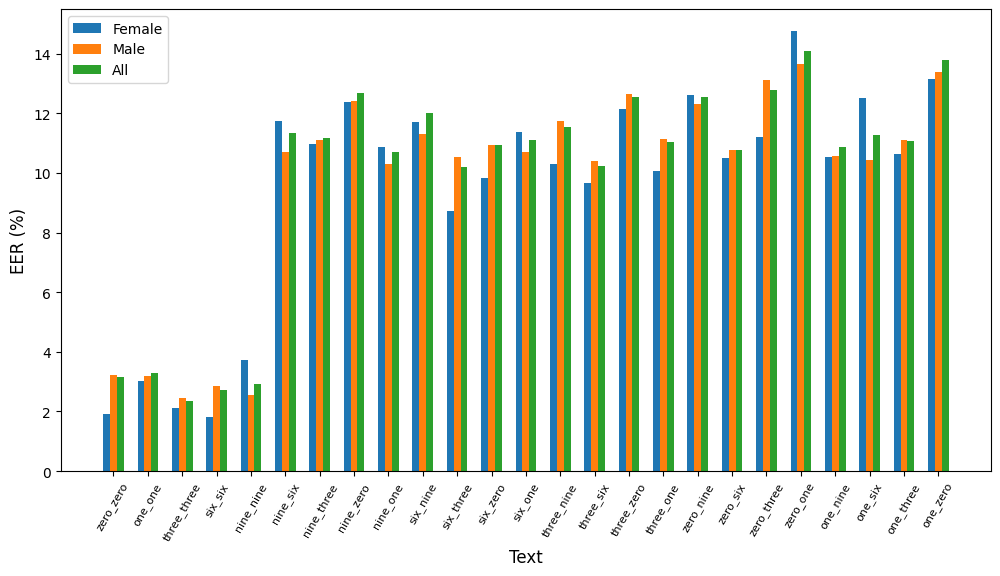

['../sync_result\\pretrain\\128_pretrained_exp1.json', '../sync_result\\pretrain\\128_pretrained_exp2.json', '../sync_result\\pretrain\\128_pretrained_exp3.json']


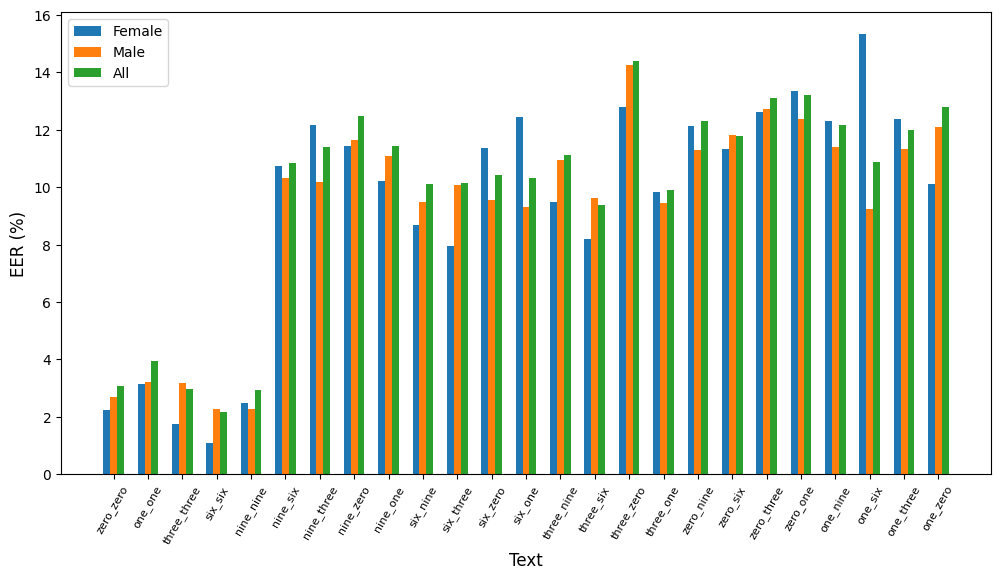

In [35]:
# Experiments
loop = 2
PATH = '../sync_result'
channels = [1024,128]
techniques = ['pretrain']
genders = ['female', 'male', 'all']
phases = ['eval']
digits = ['9', '6', '3', '0','1']
words = list(permutations(digits,r=2))
text = digits + ['_'.join(word) for word in words]
for c in channels:
    for tech in techniques:
        key = '%s_%s' % (c, tech)
        files = glob.glob(os.path.join(PATH, tech, "%s_%s_exp*.json"%(c,'experiment')))
        # print(files)
        # path_to_save = os.path.join(PATH,'new_images',key)
        average_1 = compute_average_result(files, type='json')
        
        if tech == 'non_pretrain':
            files = glob.glob(os.path.join(PATH, tech, "%s_%s_exp*.json"%(c,'non-pretrained')))
        else:
            files = glob.glob(os.path.join(PATH, tech, "%s_%s_exp*.json"%(c,'pretrained')))
        print(files)
        average_2 = compute_average_result(files,type='json')
        loop2 = get_loop_from_average(average_2,2,digits=digits)
        
        for gender in ['female', 'male', 'all']:
            for digit in sorted(digits):
                loop2['eval'][gender]['eer']['%s_%s'%(digit,digit)] = loop2['eval'][gender]['eer'][digit]
                del loop2['eval'][gender]['eer'][digit]
            loop2['eval'][gender]['eer'].update(average_1['eval'][gender]['eer'])
            loop2['eval'][gender]['minDCF'].update(average_1['eval'][gender]['minDCF'])
        path_to_save = os.path.join(PATH,'new_images/loop2',key + '_loop_and_concat.png')
        os.makedirs( os.path.join(PATH,'new_images/loop2'), exist_ok=True)
        # print(average_1)
        draw_bar_chart(loop2['eval'],path_to_save=path_to_save)
        # draw_bar_chart(get_loop_from_average(average_2,1)['eval'])
        # print(average_2)
        


# Visualization spoken digits from the difference of channel

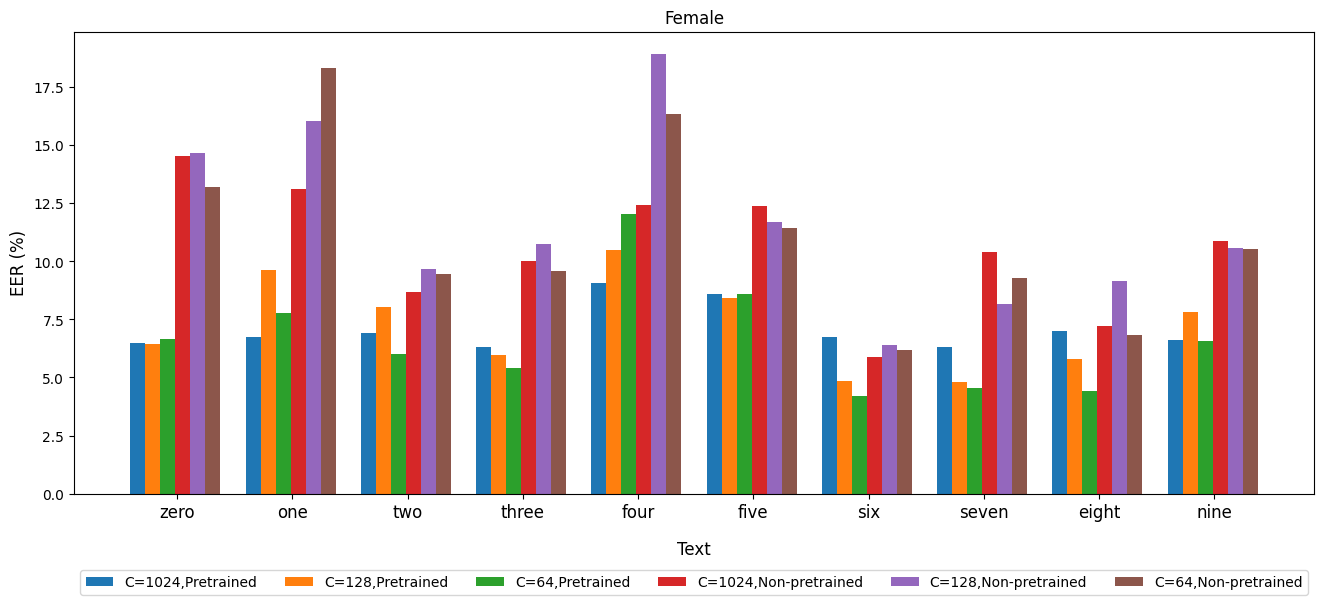

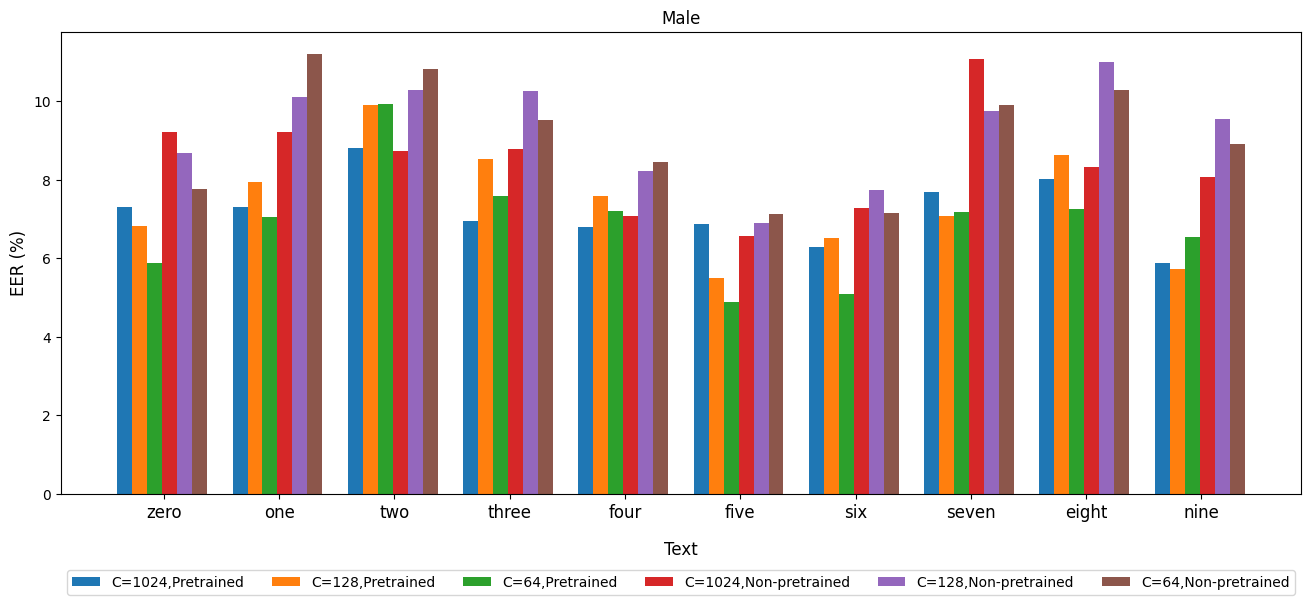

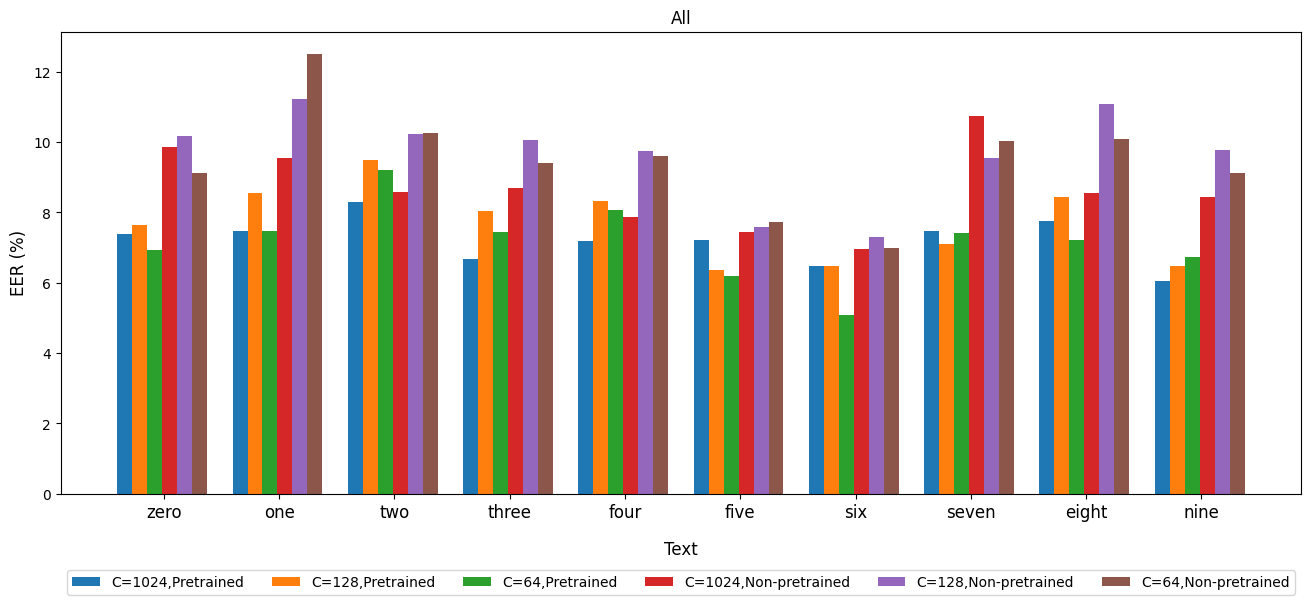

In [36]:
# Experiments
PATH = '../sync_result'
channels = [1024,128,64]
techniques = ['pretrain','non_pretrain']
genders = ['female', 'male', 'all']
phases = ['eval']
data = {}
for tech in techniques:
    for c in channels:
        key = '%s_%s' % (c, tech)
        files = glob.glob(os.path.join(PATH, tech, "%s_%s_exp*.json"%(c,'experiment')))
        if tech == 'non_pretrain':
            files = glob.glob(os.path.join(PATH, tech, "%s_%s_exp*.json"%(c,'non-pretrained')))
        else:
            files = glob.glob(os.path.join(PATH, tech, "%s_%s_exp*.json"%(c,'pretrained')))
        average_loop1 = compute_average_result(files,type='json')
        loop1 = get_loop_from_average(average_loop1,1,digits=None)
        data['%s_%s'%(c,tech)] = loop1['eval']
        


bar_width = 0.13
group_spacing = 0.2
len_columns = 10 # 10 digits
len_groups = len(list(data.keys()))
for gender in genders:
    align = -(len_groups*bar_width)/2 + 0.05
    fig = plt.figure(figsize=(16,6))
    axis = fig.add_subplot()
    for (i,c) in enumerate(data):
        axis.bar(np.arange(len(data[c][gender]['eer']))  + align, list(data[c][gender]['eer'].values()),width=bar_width)
        align = align + bar_width  
    legends = []
    for k in data.keys():
        pattern = 'C=%s,%s'
        tech = 'Non-pretrained' if 'non_pretrain' in k else 'Pretrained'
        c = k.split('_')[0]
        legends.append(pattern%(c,tech))
    axis.set_xlabel('Text',fontsize=12)
    axis.xaxis.set_label_coords(0.5,-0.1)
    axis.set_ylabel('EER (%)',fontsize=12)
    axis.legend(legends, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6)
    texts = [i for i in range(10)]
    # axis.set_xticklabels([DIGIT_MAPPING[text] for text in texts],fontsize=12, rotation=30)
    # axis.set_xticks(np.arange(len_columns)+ ((len_groups - 1) / 2)*(bar_width * len_columns) + group_spacing)
    plt.xticks(ticks=range(10),labels=[DIGIT_MAPPING[text] for text in texts],fontsize=12, rotation=0)
    plt.title(gender.capitalize())
    # plt.savefig('sync_result/new_images/comparison_%s.png'%gender,bbox_inches='tight')
    plt.show()

# Compare pretrained and non-pretrained

In [38]:
PATH = '../sync_result'
channels = [1024,128,64]
techniques = ['pretrain','non_pretrain']
genders = ['female', 'male', 'all']
phases = ['eval']
data = {}
for c in channels:
    data[c] = {}
    for tech in techniques:
        key = '%s_%s' % (c, tech)
        files = glob.glob(os.path.join(PATH, tech, "%s_%s_exp*.json"%(c,'experiment')))
        if tech == 'non_pretrain':
            files = glob.glob(os.path.join(PATH, tech, "%s_%s_exp*.json"%(c,'non-pretrained')))
        else:
            files = glob.glob(os.path.join(PATH, tech, "%s_%s_exp*.json"%(c,'pretrained')))
        average = compute_average_result(files,type='json')['eval']
        # loop1 = get_loop_from_average(average_loop1,1,digits=None)
        # data['%s_%s'%(c,tech)] = loop1['eval']
        data[c][tech] = average
        

def visualize_result_by_goal(data, 
                            goal='techniques',
                            metric='eer', 
                            start_loop=1, 
                            end_loop=5,
                            channels=[1024,128,64],
                            genders=['female', 'male', 'all'],
                            techniques=['non_pretrain', 'pretrain']):
    # assert goal in ['techniques' 'genders']
    for c in channels:
        for gender in genders:
            if goal == 'techniques':
                all = []
                for tech in techniques:
                    if len(all) == 0:
                        all = np.array(list(data[c][tech][gender][metric].values()))
                    else:
                        all = np.concatenate([all,np.array(list(data[c][tech][gender][metric].values()))], axis=0)
                min_ = np.min(all)
                max_ = np.max(all)
            for tech in techniques:
                if goal == 'genders':
                    all = []
                    for g in genders:
                        if len(all) == 0:
                            all = np.array(list(data[c][tech][g][metric].values()))
                        else:
                            all = np.concatenate([all,np.array(list(data[c][tech][g][metric].values()))], axis=0)
                    min_ = np.min(all)
                    max_ = np.max(all)
                # print(c, gender, tech)
                fig = plt.figure(figsize=(8,4))
                ax = fig.add_subplot(111)
                for i in range(0,10):
                    try:
                        ax.plot([j for j in range(start_loop, end_loop+1)],data[c][tech][gender][metric][i])
                    except:
                        ax.plot([j for j in range(start_loop, end_loop+1)],data[c][tech][gender][metric][str(i)])
                ax.set_xticks([ i for i in range(start_loop,end_loop+1)])
                ax.set_xlabel('The number of repetitions')
                ax.set_ylim((min_-0.5,max_+0.5))
                if metric == 'eer':
                    y_label = 'EER (%)'
                else:
                    y_label = 'minDCF'

                ax.set_ylabel(y_label)
                ax.set_title(gender.capitalize())
                ax.grid(linestyle='--')
                # ax.legend([DIGIT_MAPPING[i] for i in range(0,10)], loc='upper left', ncol=1, bbox_to_anchor=[1,1], title='Text')
                plt.legend([DIGIT_MAPPING[i] for i in range(0,10)], loc='upper left', ncol=1, bbox_to_anchor=[1,1], title='Text')
                
                path_folder = os.path.join(PATH, 'new_images', goal)
                if not os.path.exists(path_folder):
                    os.mkdir(path_folder)
                path_to_save = os.path.join(path_folder,'%s_%s_%s.png'%(c,tech,gender))
                if path_to_save is not None:
                    plt.savefig(path_to_save, bbox_inches='tight')
                plt.show()


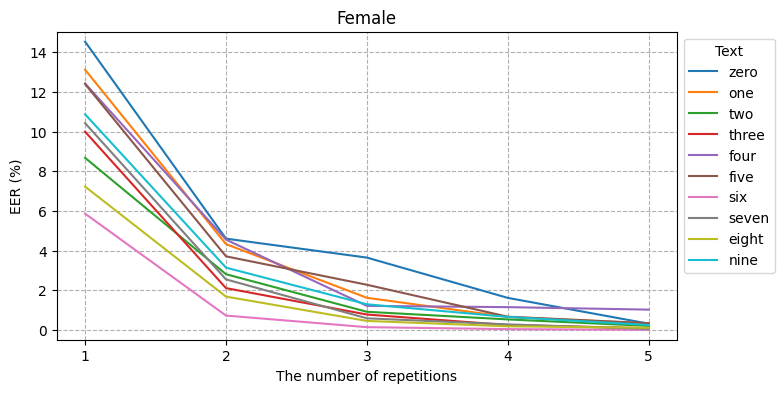

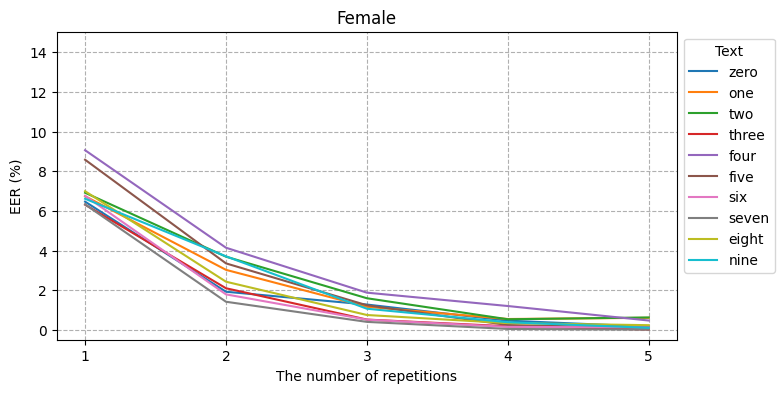

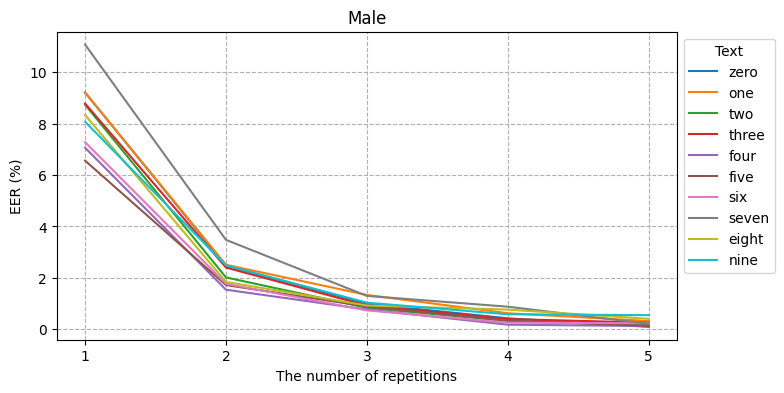

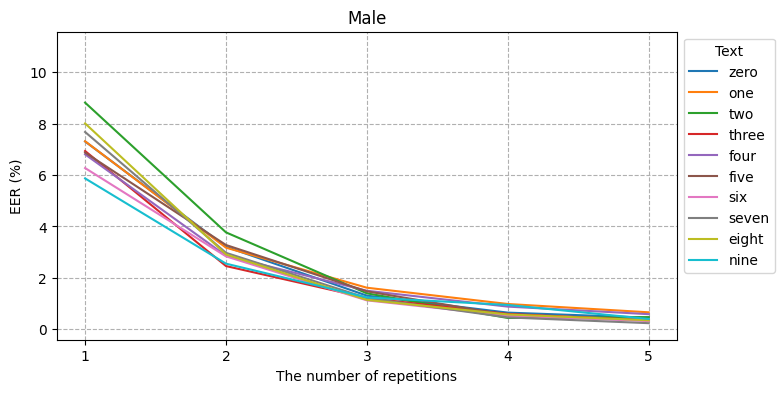

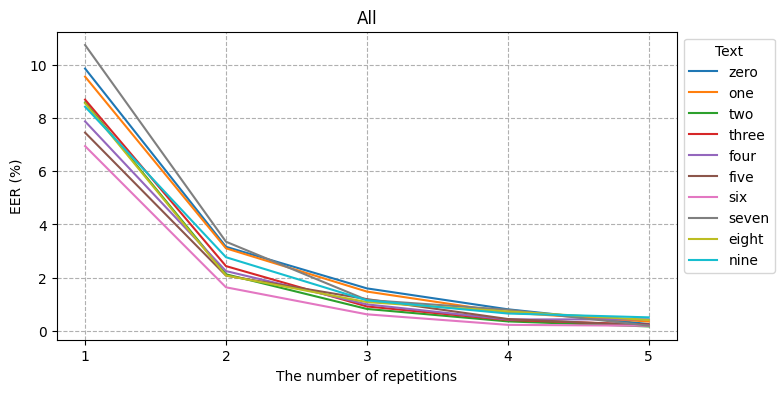

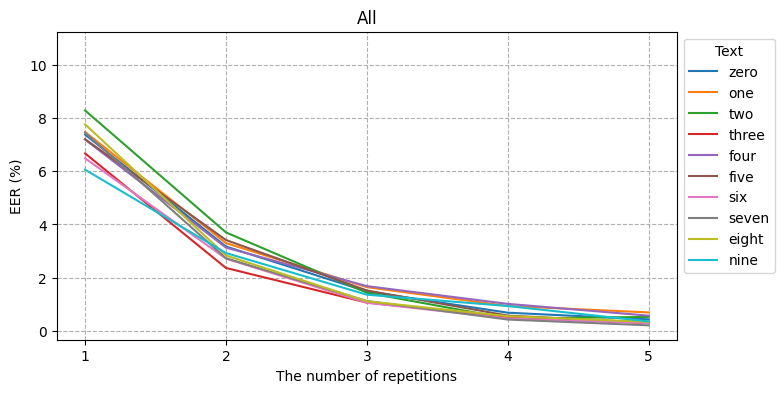

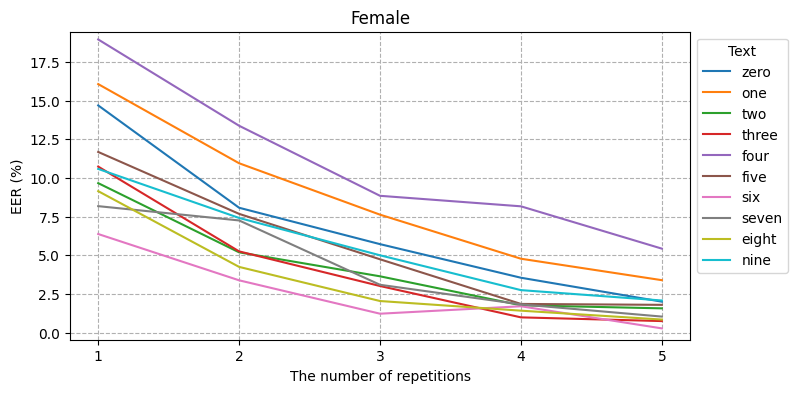

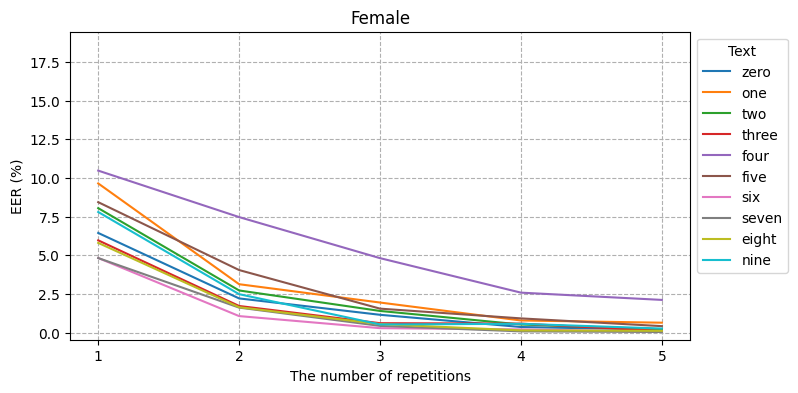

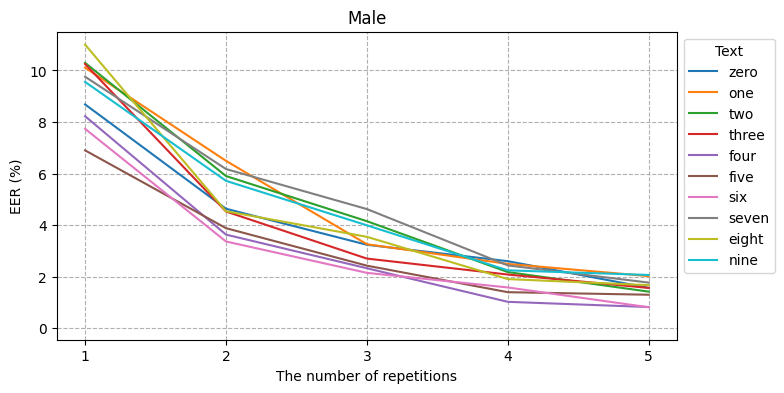

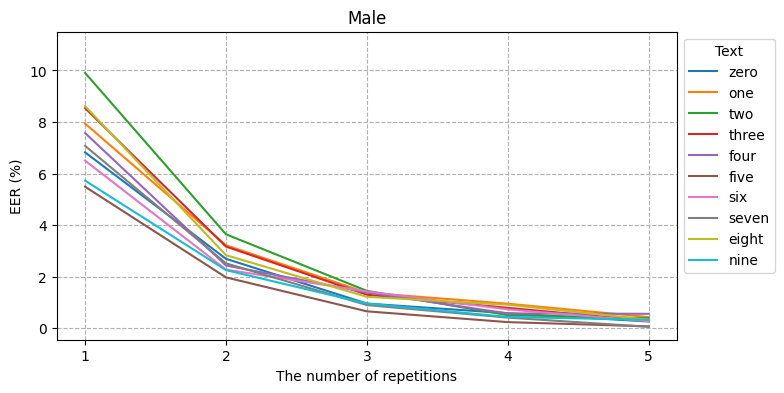

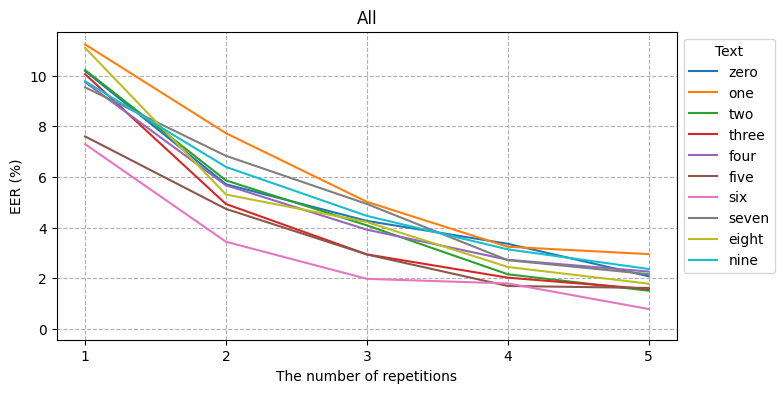

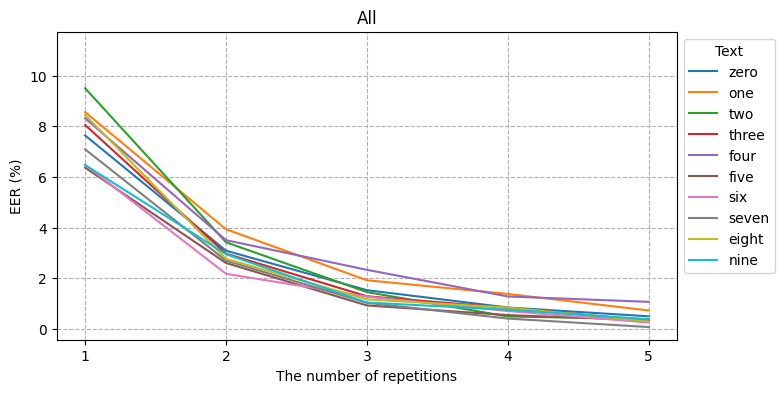

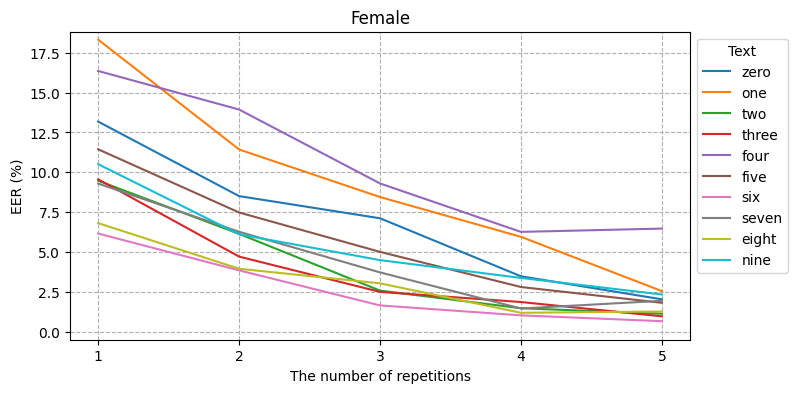

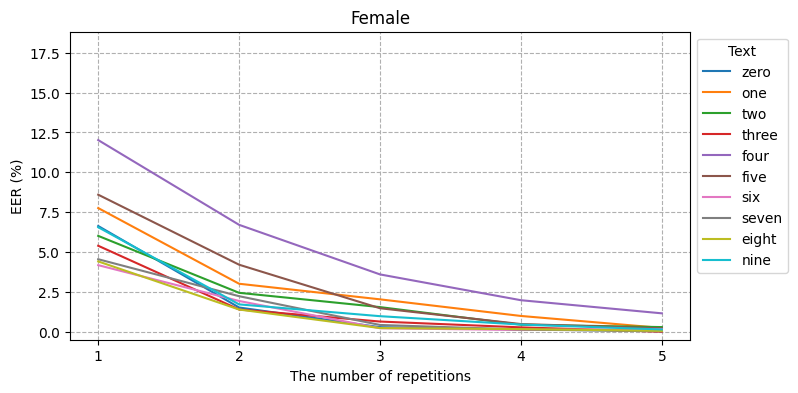

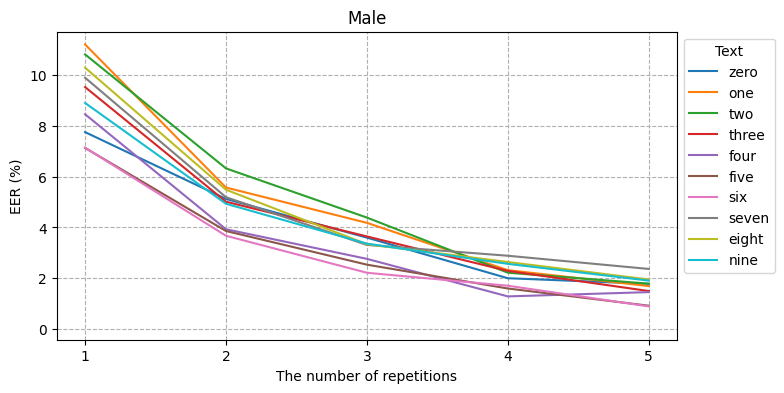

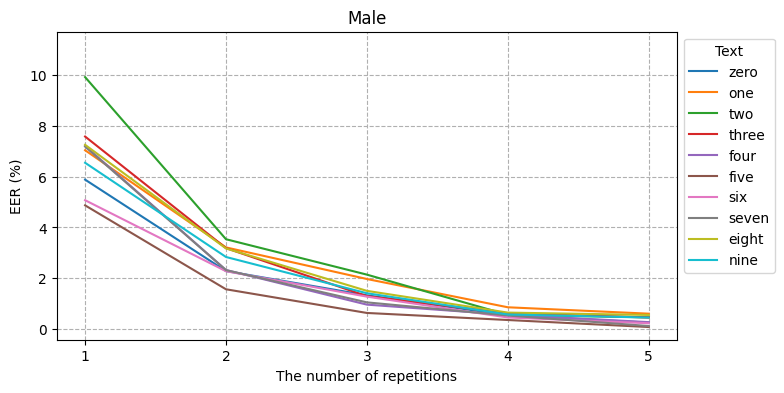

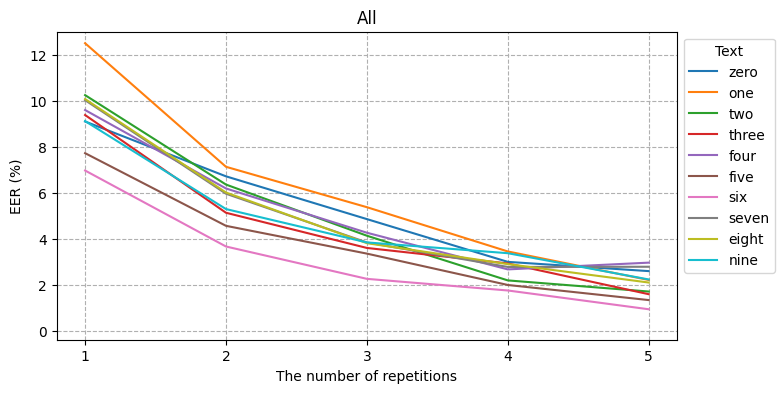

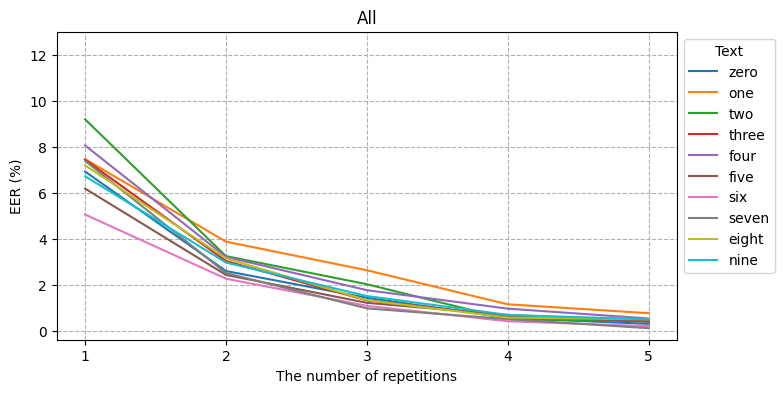

In [39]:
visualize_result_by_goal(data,goal='techniques')

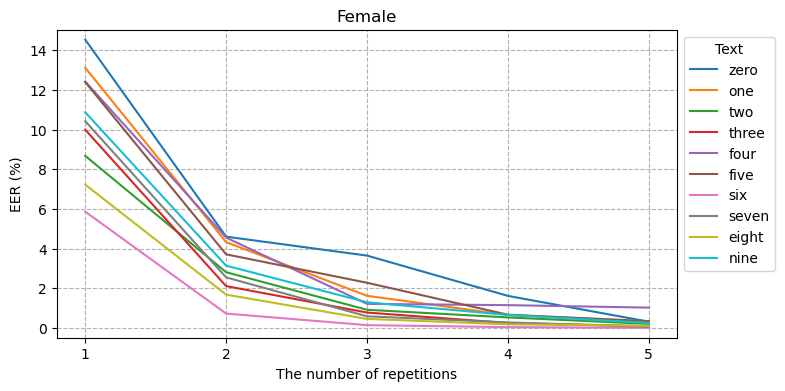

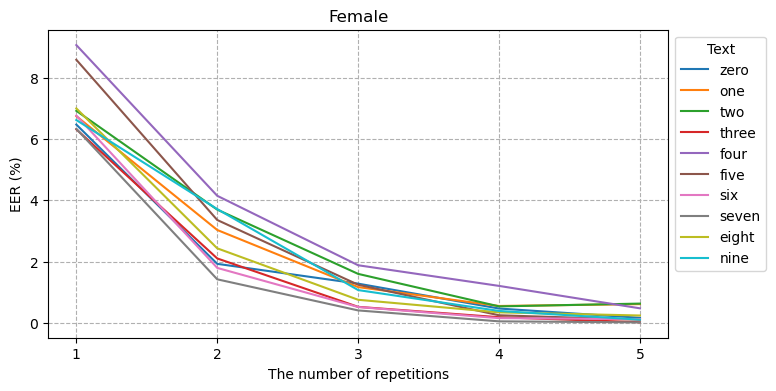

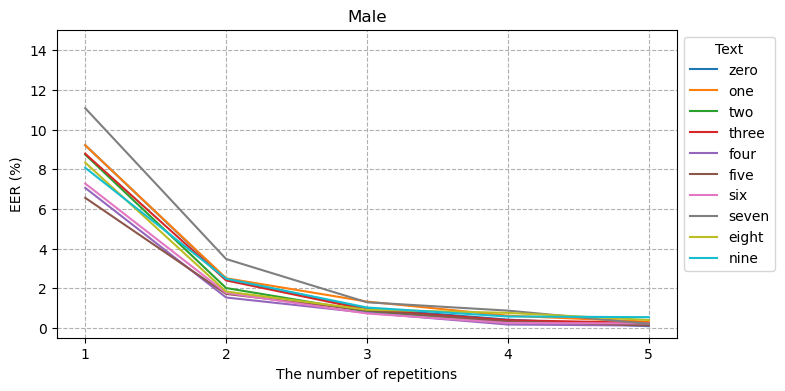

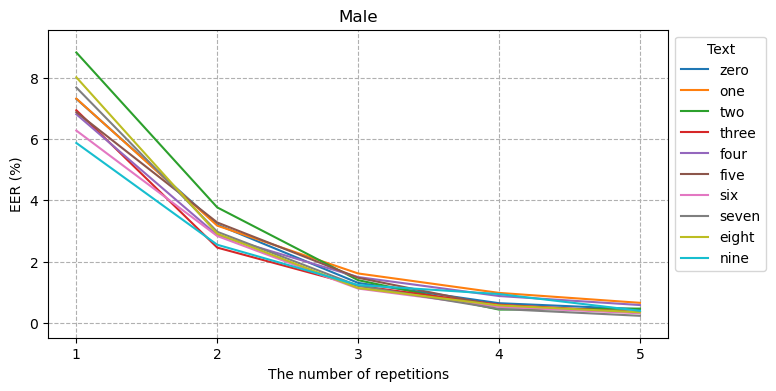

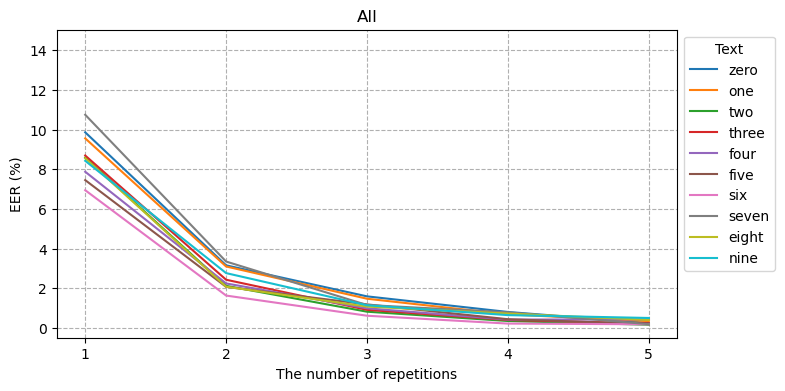

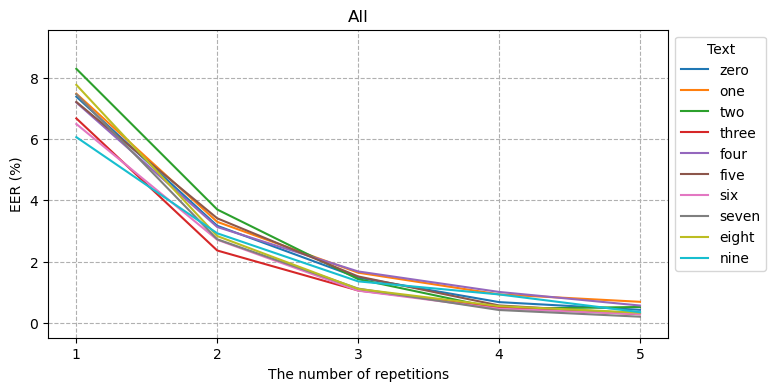

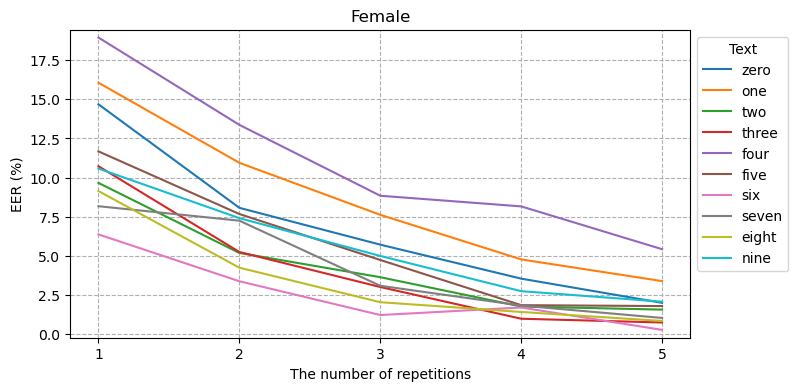

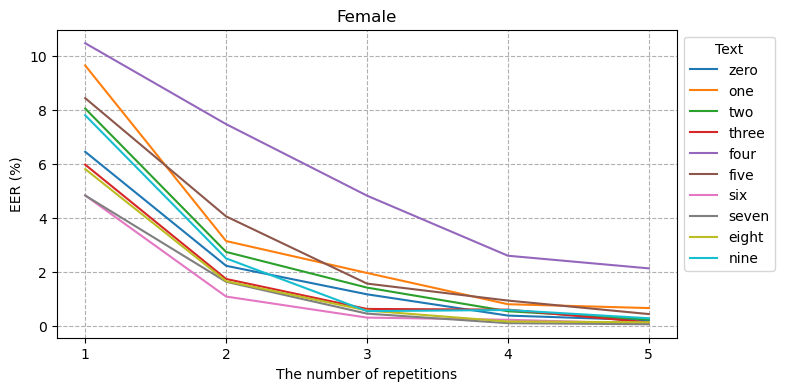

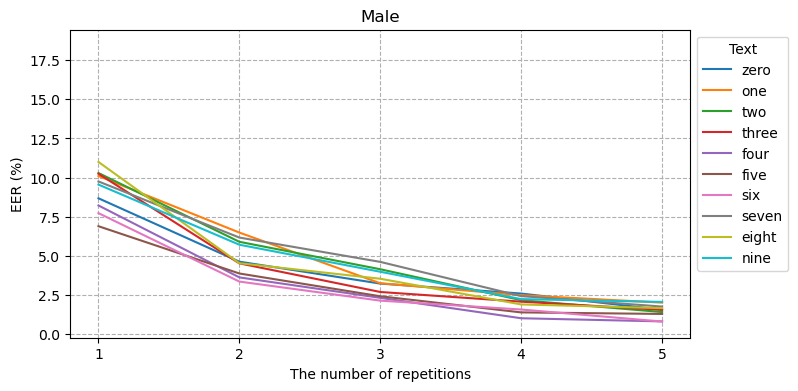

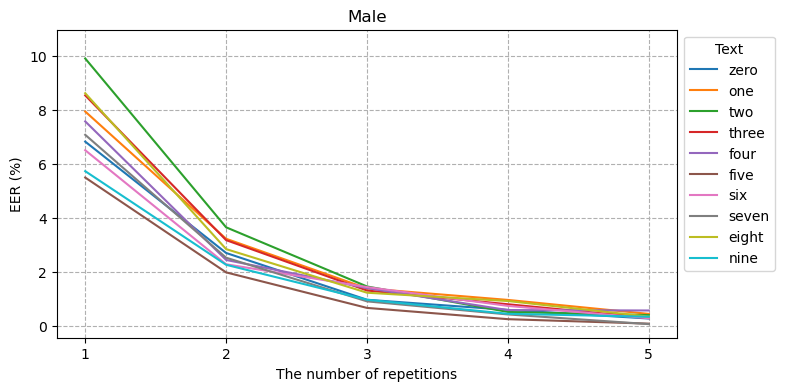

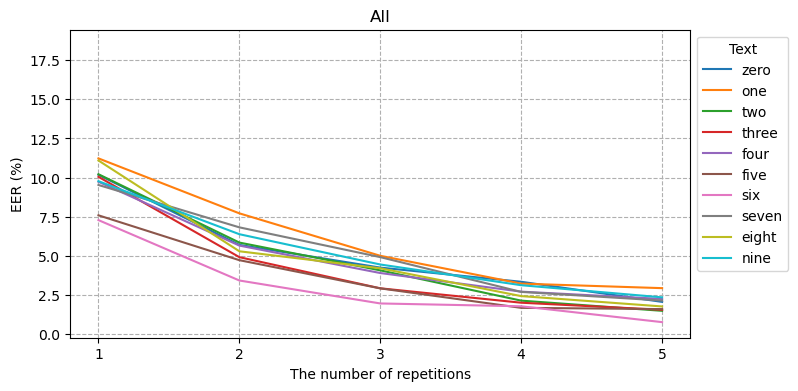

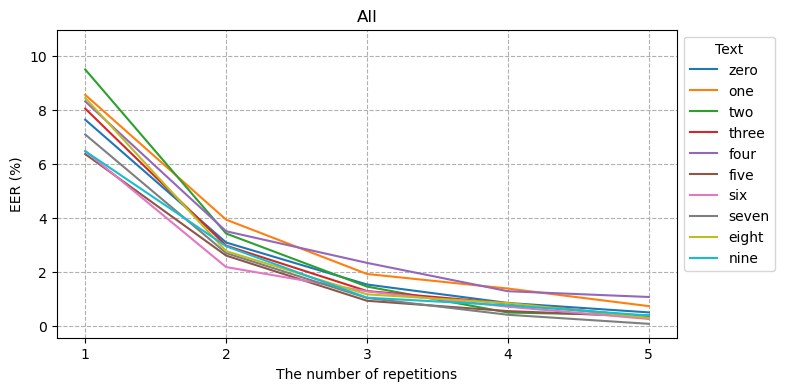

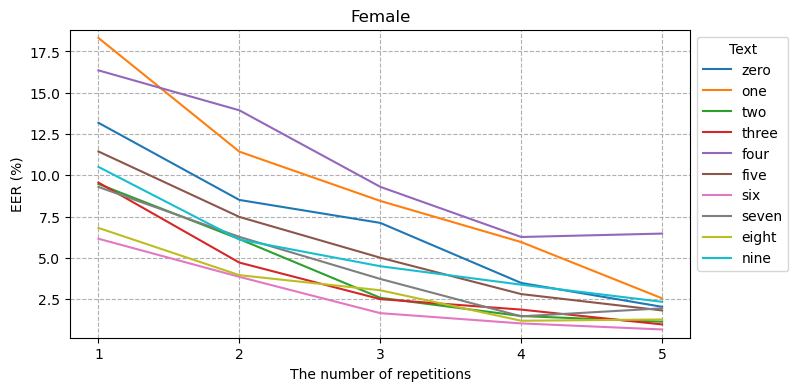

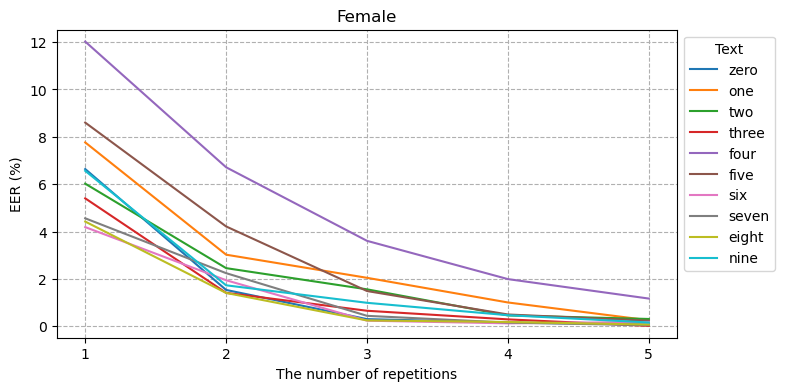

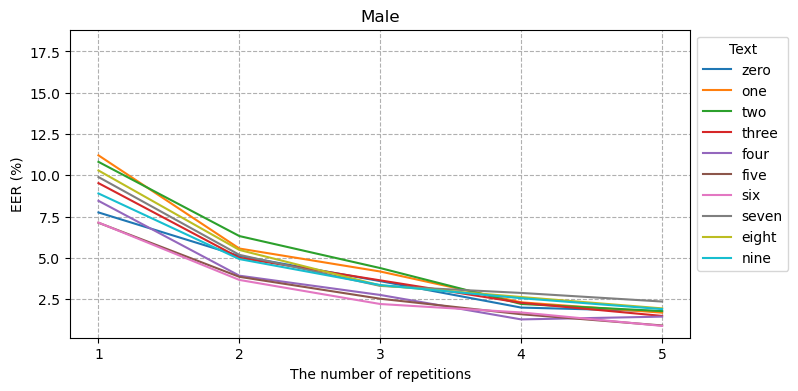

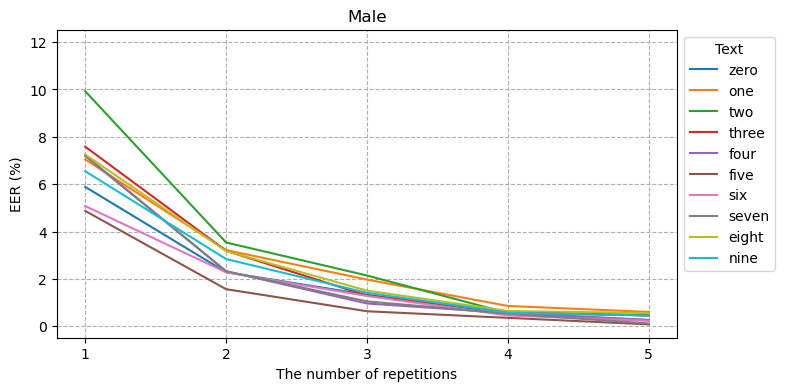

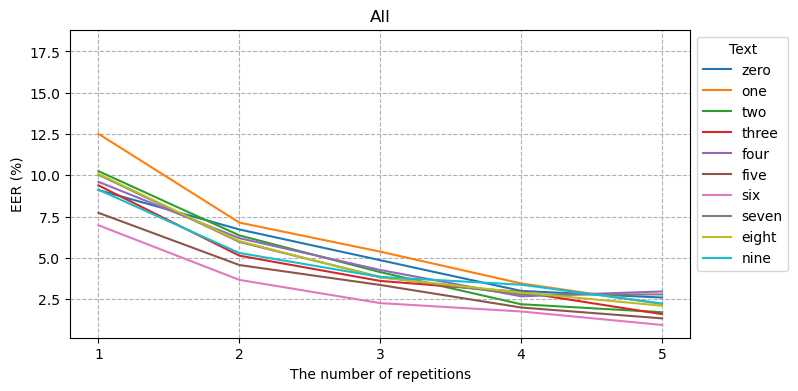

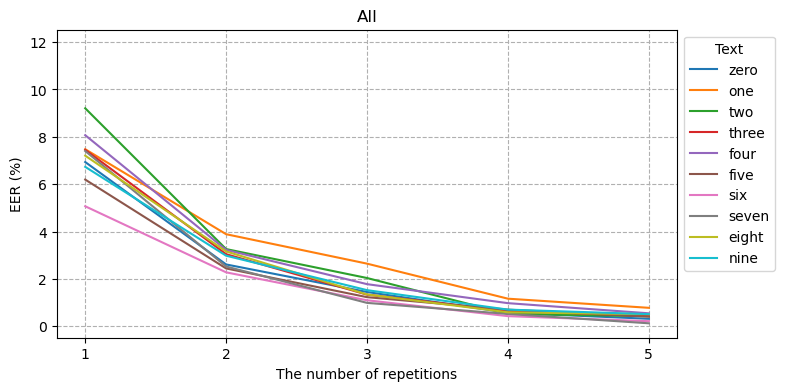

In [ ]:
visualize_result_by_goal(data, goal='genders')

# Real data

In [40]:
PATH = '../sync_result/real_data'
channels = [1024,128,64]
# techniques = ['non_pretrain','pretrain']
result = {}
for c in channels:
    for tech in ['non-pretrained', 'pretrained']:
        path_to_save = os.path.join(PATH,'images','%s_%s_tw.png'%(c,tech))
        if c == 1024 and tech == 'pretrained':
            average = json.load(open(PATH + '/1024_pretrained_tw.json', 'r'))
            # visualize_result(average,genders=['male'],
            #              path_to_save=path_to_save,limit=True)
            result["%s_%s"%(c,tech)] = np.mean(np.array(list(average['eval']['male']['eer'].values())),axis=0)
            continue
        files = glob.glob(os.path.join(PATH, 'temp', "%s_%s_exp*.json"%(c,tech)))
        print(path_to_save)
        average = compute_average_result(files,
                                         type='json')
        avg_loop = np.array(list(average['eval']['male']['eer'].values()))
        result["%s_%s"%(c,tech)] = np.mean(avg_loop, axis=0)
        # json.dump(average, open(os.path.join(PATH,'%s_%s_tw.json'%(c,tech)), 'w'))
        # # print(key)
        # visualize_result(average,genders=['male'],
        #                  path_to_save=path_to_save,limit=True)

../sync_result/real_data\images\1024_non-pretrained_tw.png
../sync_result/real_data\images\128_non-pretrained_tw.png
../sync_result/real_data\images\128_pretrained_tw.png
../sync_result/real_data\images\64_non-pretrained_tw.png
../sync_result/real_data\images\64_pretrained_tw.png


In [41]:
result

{'1024_non-pretrained': array([13.26023392,  7.76851852,  5.88499025,  5.04141702,  5.99815241]),
 '1024_pretrained': array([7.85721248, 4.5462963 , 3.19736842, 2.66002643, 3.63669673]),
 '128_non-pretrained': array([12.98489279,  9.66666667,  7.11159844,  8.8539686 ,  7.66289085]),
 '128_pretrained': array([8.64863548, 4.91666667, 3.23635478, 3.61420849, 3.55864603]),
 '64_non-pretrained': array([12.27436647,  9.88888889,  7.28411306,  8.27279984,  8.40952959]),
 '64_pretrained': array([8.56676413, 5.43518519, 3.57699805, 4.38272701, 4.9451952 ])}

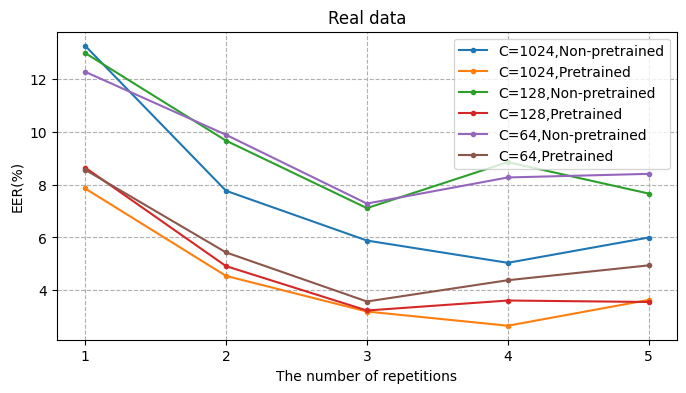

In [42]:
data = result
legends = []
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
for k in data:
    leg = 'C=%s,%s'
    if 'non-pretrained' in k:
        tech_str = 'Non-pretrained'
    else:
        tech_str = 'Pretrained'
    
    C = k.split('_')[0]
    legends.append(leg%(C,tech_str))
    ax.plot([loop for loop in range(1,6)],list(data[k]),marker='.')
plt.title('Real data')
plt.ylabel('EER(%)')
plt.xlabel('The number of repetitions')
plt.xticks([loop for loop in range(1,6)])
plt.legend(legends)
plt.grid(linestyle='--')
# plt.savefig('sync_result/real_data/images/comparison.png')
plt.show()